In [38]:
Overview

NameError: name 'Overview' is not defined

In [5]:
import pandas as pd
import numpy as np
import os
import re
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
import zipfile
import datetime as dt

from math import ceil
from matplotlib.ticker import FuncFormatter
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [26]:
# Set up the speficiations for visualization
sns.set_style('whitegrid')
sns.set_context(rc={
    'axes.titlesize': 19,
    'axes.labelsize':15,
    'xtick.labelsize':13,
    'ytick.labelsize':13
})

In [8]:
# Set up the float representation
pd.options.display.float_format='{:,.4f}'.format

## 1 Problem definition

### What problem we are dealing with?

Let's say:<br> 
We are in a product team at a medium-sized online e-commerce business. The UX designer has just created the product page, with the aim to gain a higher percentage of visitors make a conversion.<br>
+ The current conversion rate is about 13% on average throughout the year 
+ An increase of 2% would be considered a success if it raises the __conversion rate to 15%__.

Before rolling out the change, we would like to run an A/B test it on a small number of users to see how the product page performs to see whether it leads to  higher conversion rate.

### Why does that matter? 

For any profit driven businesses, we try to maximize the profits by increasing revenues or reducing costs or by combining both.<br>
Higher conversion rate means that we successfully convert more visitors to our customers => more revenues for the business 


## 2 Design the experiment

### Step 1 Identify the key performance indicators being of business's interest?

The metric of interest in this context is the conversion rate which is computed as follows:<br>  $ConversionRate =\frac{totalNumberConversions}{totalNumberVisitors}$

The metric is measurable since we could track both the numerator and the denominator(e.g: Google Analytics could provide with that information)

### Step 2 Fomulate the null and the alternative hypothesis

We'll need two groups:
>+ A control group - They'll be shown the old design
>+ A treatment (or experimental) group - They'll be shown the new design<br>

+ __Null hypotheis H0__: There is no difference in the conversion rate betwwen old design and new design (i.e: p_exp-p_con=0)
+ __Alternative hypothesis H1__: The new design leads to higher conversion rate (i.e: p_exp-p_con>0)(i.e: That only when the new design outperforms matters to us)

=> Given the input, the one-tailed t-test seems to be a proper one.

### Step 3 Decide on the significant level, statistical power and practical significant level

Let's say we set:<br>
+ __Significant level $\alpha$__: .05
+ __Practical significant level__: As said in the intro, only the outperformance of at least 2% would be of our interest.
+ __Statistical power ($1- \beta$)__:  This represents the probability of spotting a statistical difference between the groups in our test when a difference is present. This is usually set at 0.8 as a convention

### Step 4 Calculate sample size

__n= $\frac{2\bar{p}(1-\bar{p})(Z_{1-\beta} +Z_{\alpha/2})^{2}}{mde^{2}}$__<br>

where 
+ $\bar{p}$ in this context is the baseline conversion rate<br>
+ $Z_{1-\beta}$ is the Z-score of statistical power
+ $Z_{\alpha/2}$ is the Z-score of $\alpha/2$
+ mde is the minimum detectable effect which indicates the minimum level of effect size that our test could spot if there exists such difference 

https://dimewiki.worldbank.org/Power_Calculations


In [22]:
def min_sample_size(bcr, mde,power=.8, alpha=.05):
    """
    Fuction is used to identify the sample size needed 
    Functions requires  2 manadatory parameters:
    + bcr which is the baseline conversion rate
    + mde which is the minimum detectable effect
    It returns minimum sample size in float
    """
    #Create the standard normal distribution object
    standard_normal= stats.norm(0,1)
    
    #Compute Z_stat_power
    Z_beta= standard_normal.ppf(power)
    
    #Compute Z_alpha
    Z_alpha= standard_normal.ppf(1-(alpha/2))
    
    # average of probabilities from both groups
    pooled_prob= (bcr+bcr+mde)/2
    
    min_N= (2*pooled_prob*(1-pooled_prob)*(Z_beta+Z_alpha)**2
            /mde**2)
    
    return min_N

In [23]:
required_n=min_sample_size(.13,.02)
print('The sample size needed for this experiment is {:,.2f}'.format(required_n))

The sample size needed for this experiment is 4,725.03


## 3 Conduct the experiment

Usually, at this point, we would need to collect the data.by working with our team to set up the experiment and running it.<br>
However, since we'll use a dataset that we found online, in order to simulate this situation we'll:<br>
+ Fetch the dataset from Kaggle
+ Read the data into a pandas DataFrame
+ Conduct EDA
+ Randomly sample n=4726 rows from the DataFrame for each group

In [1]:
# Use Kaggle API to fetch the data needed
!kaggle datasets download -d zhangluyuan/ab-testing 

ab-testing.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
# Unzip data file to targetdir folder
with zipfile.ZipFile('ab-testing.zip','r') as zip_ref:
    zip_ref.extractall('targetdir')

In [4]:
path='/targetdir'

In [6]:
# Load the dataset
full_data= pd.read_csv(os.getcwd()+path+'/'+'ab_data.csv')

### a/ Exploratory data analysis

#### Data quality assessment

In [16]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


__Generally__:<br>
+ The dataset has around 300,000 observations and 5 columns
+ The data types for all columns seem to be appropriate except the one in timestamp column. datetime type would be prefered
+ We could also consider optimizing the memory usage by converting object dtype to categorical type for discrete columns like group and landing_page

In [17]:
# Top 5 rows
full_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#### Data cleaning 
(duplication, missingness, inappropriate data types)

In [7]:
# Duplication
print('There are {} users appearing multiple times in the dataset'.format(full_data['user_id'].duplicated().sum(axis=0)))

There are 3894 users appearing multiple times in the dataset


In [14]:
# Keep only the first observation for each user_id given ascendingly sorted timestamp value 
distinct_data= full_data.sort_values('timestamp').drop_duplicates('user_id')

In [20]:
distinct_data

,user_id,timestamp,group,landing_page,converted
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0
...,...,...,...,...,...
158814,799244,2017-01-24 13:41:15.325359,treatment,new_page,0
47535,808330,2017-01-24 13:41:19.152664,control,old_page,0
157787,843121,2017-01-24 13:41:44.097174,treatment,new_page,0
179072,836373,2017-01-24 13:41:52.604673,control,old_page,0


In [15]:
# Missingness
distinct_data.isnull().sum(axis=0).to_frame().rename({0:'Number of missing values'},axis=1)

,Number of missing values
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


There is no missingness in the dataset

In [16]:
# Convert object type to categorical type, and datetimes for some suitable columns
dist_data_conv=distinct_data.astype({'group':'category','landing_page':'category'})
dist_data_conv['timestamp']=pd.to_datetime(dist_data_conv['timestamp'])

In [22]:
dist_data_conv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 131228 to 193652
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       290584 non-null  int64         
 1   timestamp     290584 non-null  datetime64[ns]
 2   group         290584 non-null  category      
 3   landing_page  290584 non-null  category      
 4   converted     290584 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(2)
memory usage: 9.4 MB


Notice that the memory usage has been reduced from 11.2+MB to 9.4 MB. This is just a minor improvement but the effect would be greater in case of having larger dataset

In [17]:
dist_data_conv.groupby(['group','landing_page'])['timestamp']\
              .agg('count')\
              .reset_index()\
              .pivot(index='group',
                     columns='landing_page',
                     values='timestamp')

landing_page,new_page,old_page
group,,
control,975,144319
treatment,144316,974


To ensure all users in the control group are seeing the old page and viceversa, we remove any observations belonging to control group but seeing new_page and viceversa

In [18]:
# Set the conditions to keep only the "control and old page" or "treatment and new page" rows
c1= dist_data_conv['group']=='control'
c2= dist_data_conv['landing_page']=='old_page'
t1= dist_data_conv['group']=='treatment'
t2= dist_data_conv['landing_page']=='new_page'

right_group_page= dist_data_conv[(c1&c2) | (t1&t2)]

In [19]:
right_group_page.groupby(['group','landing_page'])['user_id']\
                .agg('count')\
                .reset_index()\
                .pivot(index='group',
                       columns='landing_page',
                       values='user_id')

landing_page,new_page,old_page
group,,
control,0,144319
treatment,144316,0


It worked

### b/ Sampling

In [20]:
# Sample the same number of observations for control group and treatment group
c_group=right_group_page[right_group_page['group']=='control'].sample(n=4726,random_state=1)
t_group=right_group_page[right_group_page['group']=='treatment'].sample(n=4726,random_state=1)

#Construct the whole dataframe of interest having both groups
ab_test= pd.concat((c_group,t_group),axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [33]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,674681,2017-01-05 17:12:06.708726,control,old_page,1
1,711348,2017-01-22 04:29:11.720308,control,old_page,0
2,666692,2017-01-07 04:15:45.765594,control,old_page,0
3,922809,2017-01-10 17:51:20.655701,control,old_page,0
4,889219,2017-01-14 15:27:59.561283,control,old_page,0
...,...,...,...,...,...
9447,718541,2017-01-10 02:26:26.642005,treatment,new_page,0
9448,818076,2017-01-02 23:13:12.622475,treatment,new_page,1
9449,924396,2017-01-07 03:14:19.319972,treatment,new_page,0
9450,919330,2017-01-05 07:45:32.042049,treatment,new_page,0


In [34]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9452 entries, 0 to 9451
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       9452 non-null   int64         
 1   timestamp     9452 non-null   datetime64[ns]
 2   group         9452 non-null   category      
 3   landing_page  9452 non-null   category      
 4   converted     9452 non-null   int64         
dtypes: category(2), datetime64[ns](1), int64(2)
memory usage: 240.4 KB


In [35]:
ab_test.groupby('group')['user_id']\
       .agg('count')\
       .reset_index()

,group,user_id
0,control,4726
1,treatment,4726


Great, it seems that everything functioned properly

### c/ Visual data exploratory

In [24]:
# Lambda function that is used to compute the standard error
func= lambda x: x.std()/np.sqrt(required_n)

# Create summary table
summary= ab_test.groupby('group')['converted']\
                .agg([np.mean,np.std,func])\
                .reset_index()\
                .rename({'<lambda_0>':'s.e'},axis=1)

In [41]:
summary

,group,mean,std,s.e
0,control,0.1210,0.3262,0.0047
1,treatment,0.1126,0.3161,0.0046


C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


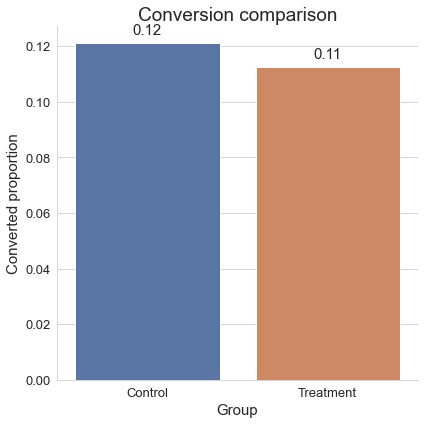

In [31]:
g= sns.FacetGrid(data=summary,height=6)
g.map(sns.barplot,'group','mean',palette=sns.color_palette('deep'))
g.set(title='Conversion comparison')
g.set_axis_labels('Group','Converted proportion')
g.set_xticklabels(['Control','Treatment'])
ax= g.axes[0][0]
for p in ax.patches:
    ax.annotate('{:,.2f}'.format(p.get_height()), 
                xy=(p.get_x()+p.get_width()/2,p.get_height()),
                xytext=(0, 6),
                xycoords='data',
                textcoords='offset points', ha='center', va='bottom', size= 15,
                )
plt.tight_layout()
plt.show()

The conversion rates for two groups are 1% difference from each other where the conversion rate in the treatment group is lower than that of the control group.<br>
Is this difference just due to random chance?

### d/ Test the hypothesis

Given the large sample size in each group, we can use the normal approximation for calculating our p-value (i.e. z-test).

In [33]:
control_counts= ab_test[ab_test['group']=='control']['converted']
treatment_counts= ab_test[ab_test['group']=='treatment']['converted']

In [35]:
n_con= len(control_counts)
n_treat = len(treatment_counts)

successes=[treatment_counts.sum(),control_counts.sum()]
n_obs=[n_treat,n_con]

#z_score, p_value= proportions_ztest(successes,nobs=n_obs, alternative='smaller') # p_value= 0.10 = p_value of two sided case divided by 2
z_score, p_value= proportions_ztest(successes,nobs=n_obs, alternative='larger') # p_value= 0.9
#z_score, p_value= proportions_ztest(successes,nobs=n_obs, alternative='two-sided')

print('The z value computed on the basis of the observed samples is {:.2f}'.format(z_score))
print('The p value computed on the basis of the observed samples is {:.2f}'.format(p_value))

( lower_treat, lower_con), ( upper_treat, upper_con) = proportion_confint(successes, nobs=n_obs, alpha=0.05)
print()
print('95% confidence interval for the treatment group is [{:.5f}, {:.5f}]'.format(lower_treat,upper_treat))
print()
print('95% confidence interval for the control group is [{:.5f}, {:.5f}]'.format(lower_con,upper_con))

The z value computed on the basis of the observed samples is -1.28
The p value computed on the basis of the observed samples is 0.90

95% confidence interval for the treatment group is [0.10356, 0.12158]

95% confidence interval for the control group is [0.11173, 0.13033]


### e/ Result interpretations:
Given the p value =0.9 which is way above alpha =0.05, we failed to reject the null hypothesis which means that the new design page did not perform better in terms of leading higher conversion rate 

## 4. Recommendations

Decision making: It is not tempting to replace the current page with the newly designed one.